In [78]:
# Import necessary libraries
import pandas as pd
import numpy as np
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
stop_words = set(stopwords.words('english'))



[nltk_data] Downloading package punkt to /Users/fymor/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/fymor/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/fymor/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## 1) Data Cleaning
In this section, we will clean the dataset by:

- Removing missing values.
- Removing URLs, emojis, and punctuation.
- Lowercasing all text for consistency. 
- Removing duplicates

The goal is to ensure the dataset is clean and ready for further processing.

In [79]:
# Load the dataset
file_path = "cyberbullying_tweets.csv" 
df = pd.read_csv(file_path)

#  the first few rows of the dataset
print("Initial Data Overview:")
df.head()


Initial Data Overview:


,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [80]:
# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Drop rows with missing values in 'tweet_text' column
df.dropna(subset=['tweet_text'], inplace=True)



Missing Values:
tweet_text            0
cyberbullying_type    0
dtype: int64


In [81]:

# Define emoji removal pattern
emoji_pattern = re.compile("["
    u"\U0001F600-\U0001F64F"  # emoticons
    u"\U0001F300-\U0001F5FF"  # symbols & pictographs
    u"\U0001F680-\U0001F6FF"  # transport & map symbols
    u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
    u"\U00002700-\U000027BF"  # dingbats
    u"\U00002600-\U000026FF"  # misc symbols
    u"\U0001F900-\U0001F9FF"  # supplemental symbols & pictographs
    u"\U0001FA70-\U0001FAFF"  # extended pictographs
    "]+", flags=re.UNICODE)


In [82]:
def preprocess_text(text):
    """
    Preprocesses text by:
    - Lowercasing
    - Removing URLs, emojis, punctuation, and special characters
    - Removing single-character tokens

    Returns:
        str: Cleaned text
    """
    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www.\S+', '', text)

    # Remove emojis
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002700-\U000027BF"  # dingbats
        u"\U00002600-\U000026FF"  # misc symbols
        u"\U0001F900-\U0001F9FF"  # supplemental symbols & pictographs
        u"\U0001FA70-\U0001FAFF"  # extended pictographs
        "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)

    # Remove punctuation and special characters
    text = re.sub(r"’", '', text)  # Handle smart apostrophes
    text = re.sub(r"[^\w\s]", '', text)  # Remove all punctuation except word characters and spaces

    # Remove single-character tokens (except meaningful ones like 'a', 'i')
    text = re.sub(r'\b[b-z]\b', '', text)  # Exclude 'a' and 'i' from removal

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text


In [83]:
# Apply cleaning function
df['cleaned_text'] = df['tweet_text'].apply(preprocess_text)


# Verify cleaned_text contains strings
print(df['cleaned_text'].apply(type).unique())  # Should only show <class 'str'>


[<class 'str'>]


In [84]:
# Check for duplicate tweets
print("\nDuplicate Tweets:")
print(df.duplicated(subset=['cleaned_text']).sum())

# Drop duplicate tweets
df.drop_duplicates(subset=['cleaned_text'], inplace=True)

# Check duplicates again after dropping
print("\nDuplicate Tweets After Dropping:")
print(df.duplicated(subset=['cleaned_text']).sum())



Duplicate Tweets:
2176

Duplicate Tweets After Dropping:
0


## 2) Tokenization and Lemmatization
Here we tokenize the text into words and lemmatize each word to its root form for normalization.

In [85]:
# Define helper functions for tokenization and lemmatization
def get_wordnet_pos(treebank_tag):
    """
    Converts Treebank POS tags to WordNet POS tags.
    """
    if treebank_tag.startswith('J'):
        return nltk.corpus.wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return nltk.corpus.wordnet.VERB
    elif treebank_tag.startswith('R'):
        return nltk.corpus.wordnet.ADV
    else:
        return nltk.corpus.wordnet.NOUN


In [86]:
# adding to stopwords: i noticed that some words are not useful for the analysis
custom_stopwords = {'get'}  # Add any other unhelpful tokens
stop_words.update(custom_stopwords)

In [87]:
def tokenize_and_lemmatize(text):
    """
    Tokenizes and lemmatizes cleaned text.

    Returns:
        List[str]: Processed tokens
    """
    tokens = word_tokenize(text)  # Tokenize text
    pos_tags = nltk.pos_tag(tokens)  # Part-of-speech tagging
    lemmatizer = WordNetLemmatizer()  # Initialize lemmatizer
    processed_tokens = [
        lemmatizer.lemmatize(token, pos=get_wordnet_pos(tag))
        for token, tag in pos_tags
        if token not in string.punctuation and token not in stop_words
    ]
    return processed_tokens


In [88]:
# Apply tokenization and lemmatization
df['processed_tokens'] = df['cleaned_text'].apply(tokenize_and_lemmatize)

# Save the processed dataset
df.to_csv('processed_tweets.csv', index=False)

# save into a new df
cleaned_df = pd.read_csv('processed_tweets.csv')

#### Saving and Verifying the Processed Data
Finally, we save the cleaned and tokenized dataset to a new CSV file for further analysis or modeling.

In [89]:
# Display sample processed tokens
print("\nSample Processed Data:")
print(df[['processed_tokens']].head())



Sample Processed Data:
                                    processed_tokens
0       [word, katandandre, food, crapilicious, mkr]
1  [aussietv, white, mkr, theblock, imacelebritya...
2  [xochitlsuckkks, classy, whore, red, velvet, c...
3  [jason_gio, meh, thanks, head, concern, anothe...
4  [rudhoeenglish, isi, account, pretend, kurdish...


## 4) Exploratory Data Analysis (EDA)
In this section we will analyze the class distribution to understand the data better.

In [90]:
print("\nClass Distribution:")
print(df['cyberbullying_type'].value_counts())



Class Distribution:
cyberbullying_type
religion               7965
age                    7934
ethnicity              7909
not_cyberbullying      7852
gender                 7728
other_cyberbullying    6128
Name: count, dtype: int64


/var/folders/gx/r2dxbpbn79jbpfyjy53q29sc0000gn/T/ipykernel_31841/3003362810.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')


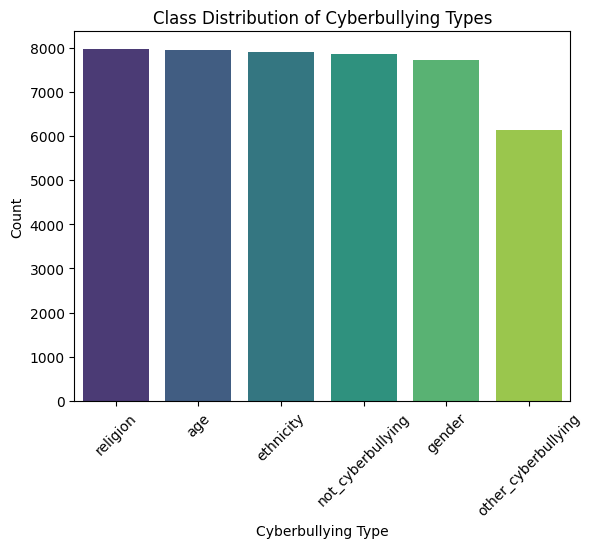

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Class distribution bar chart
class_counts = df['cyberbullying_type'].value_counts()
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.title("Class Distribution of Cyberbullying Types")
plt.xlabel("Cyberbullying Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


In [91]:
# Token frequency (flat list of all tokens)
from collections import Counter
all_tokens = [token for tokens in df['processed_tokens'] for token in tokens]
token_counts = Counter(all_tokens).most_common(10)
#print as a table
print("\nToken Frequency:")
print(pd.DataFrame(token_counts, columns=['Token', 'Frequency']))



Token Frequency:
    Token  Frequency
0   bully      10601
1  school       9108
2    fuck       7189
3    like       6134
4  nigger       5567
5    girl       5423
6    joke       5414
7    dumb       5316
8    high       5122
9  people       4809


/var/folders/gx/r2dxbpbn79jbpfyjy53q29sc0000gn/T/ipykernel_31841/194772722.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=token_df['Token'], x=token_df['Frequency'], palette='mako')


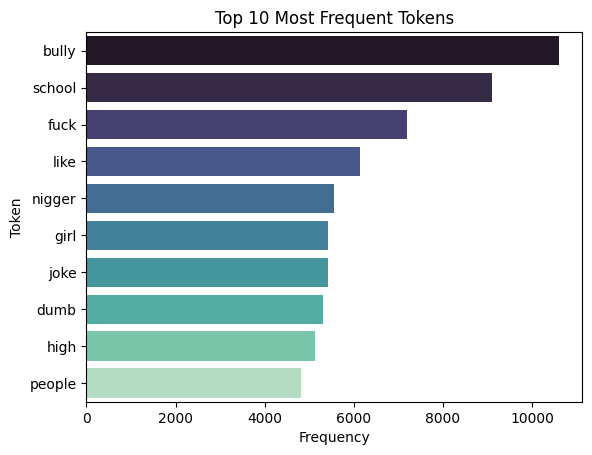

In [96]:
# Convert token frequencies into a DataFrame
token_df = pd.DataFrame(token_counts, columns=['Token', 'Frequency'])

# Token frequency bar chart
sns.barplot(y=token_df['Token'], x=token_df['Frequency'], palette='mako')
plt.title("Top 10 Most Frequent Tokens")
plt.xlabel("Frequency")
plt.ylabel("Token")
plt.show()


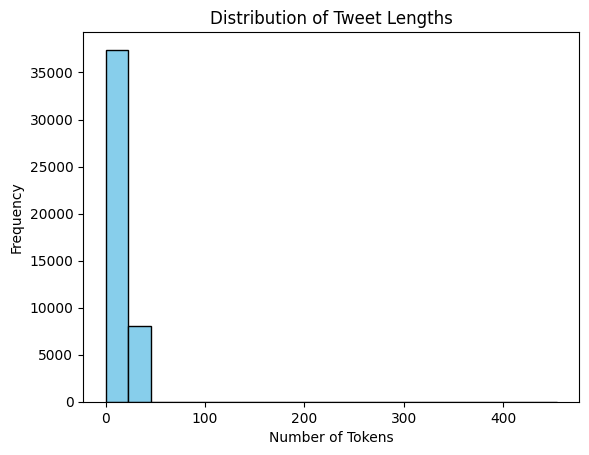

In [98]:
# Compute tweet lengths
df['tweet_length'] = df['processed_tokens'].apply(len)

# Plot histogram of tweet lengths
plt.hist(df['tweet_length'], bins=20, color='skyblue', edgecolor='black')
plt.title("Distribution of Tweet Lengths")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.show()


/var/folders/gx/r2dxbpbn79jbpfyjy53q29sc0000gn/T/ipykernel_31841/3367712013.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cyberbullying_type', y='tweet_length', data=df, palette='Set2')


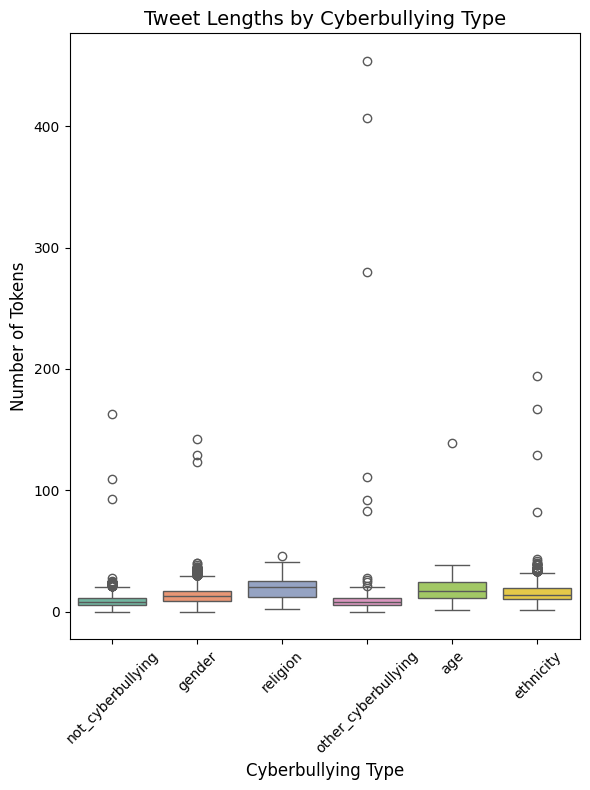

In [107]:
# Compare tweet lengths across different cyberbullying_type categories
# Boxplot of tweet lengths by cyberbullying type
plt.figure(figsize=(6, 8))
sns.boxplot(x='cyberbullying_type', y='tweet_length', data=df, palette='Set2')
plt.title("Tweet Lengths by Cyberbullying Type", fontsize=14)
plt.xlabel("Cyberbullying Type", fontsize=12)
plt.ylabel("Number of Tokens", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()  # Ensures everything fits within the figure
plt.show()


## 5) Feature Engineering
Transform processed_tokens into numerical features suitable for model input:
Bag-of-Words (BoW). 
or 
Term Frequency-Inverse Document Frequency (TF-IDF) ( i belive this is what we selected in our proposal)

## 6) Modeling
train and test model

## 7) Model Evaluation
Compare models using evaluation metrics like:
Accuracy.
Precision, Recall, and F1-Score.
Confusion matrix for deeper insights.

## 8) Stretch Goals (Optional)
can cross-compare it with our base model

- Sentiment Analysis: Pre-trained sentiment analysis - models (e.g., using TextBlob or VADER) can be applied to processed_text.
    - Compare the effectiveness of sentiment-only features against other feature engineering methods (e.g., Bag-of-Words or embeddings).
    - Test if sentiment adds value to the regular model's performance.
- Intent Detection: Use embeddings or transformer models for intent classification (if time allows).